# Transformer Notes/Implementation

These are my personal notes on transformers. I'll be thoroughly reading through [Attention is All You Need](https://arxiv.org/abs/1706.03762), the revolutionary paper that introduced the transformer architecture back in 2017. I'll also be following the implementation found in [The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/). 

I'm already somewhat familiar with transformers. My first experience with transformers was watching the associated [MIT S6.191 Lecture](https://www.youtube.com/watch?v=ySEx_Bqxvvo&t=1560s). I've also read the original paper before, and a couple of weeks ago I went through Andrej Karpathy's [Let's Build GPT: From Scratch](https://www.youtube.com/watch?v=kCc8FmEb1nY). However, I'm diving deeper since I think it's critical to understand how they work fully end to end. 

Essentially I'll have the same layout (and probably code) as the Annotated Transformer, but I'll bold different sections and elaborate on them in the following cell

**Background**

The goal of reducing **sequential computation** also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions **grows in the distance** between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the **cost of reduced effective resolution** due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first **transduction** model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

**Personal Notes**

**Sequential computation:** transformers work well with modern hardware. Specifically, models like RNN require the output of timestep $t$ to compute the output of timestep $t+1$. This doesn't work well with GPU parallelism. From my limited understanding of hardware, Central Processing Units (CPUs) are general purpose processors, which are good for a lot of things. Each individual core (your computer usually has 2, 4, 8, or 16 cores) can perform complex operations, but there are not that many of them. On the other hand, Graphics Processing Units (GPUs) have a parallel structure that consists of thousands of smaller cores. Each core has reduced functionality, but it's certainly capable of basic operations. Thus, if you have a subroutine (i.e. matrix multiplication) that you can decompose into distinct basic operations (i.e. AlphaTensor matrix multiplication algorithm for example), that subroutine may be well suited for GPU parallelism. 

**Grows in distance:** Many of these models work for sequential data, i.e. time series or language. Given a sequence, we are interested in the pairwise relationship between elements. Transformers, utilizing a self-attention mechanism, compute this relationship in constant time, whereas older architectures could only do this in nonconstant time. 

**Cost of reduced effective resolution:** The self-attention mechanism basically uses some averaging. In the same way that taking the mean of a list loses some nuances, there could be lost nuances here. 

**transduction:** transduction models learn a function mapping specific inputs to corresponding outputs, without explicitly learning one that will generalize to unseen data. For example, we want an image classifer to classify all dogs, not just the exact ones in the training set. We use transductive learning when you have a relatively small labeled dataset but a huge unlabeled dataset (i.e. machine translation)

**Model Architecture**

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1, \dots, x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, \dots, z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1, \dots, y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

In [24]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
#import spacy
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


warnings.filterwarnings("ignore")

In [25]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder      # encoder processes input seq 
        self.decoder = decoder      # decoder produces tgt seq based on encoder output
        self.src_embed = src_embed  # embeds input tokens to vector
        self.tgt_embed = tgt_embed  # embeds output tokens to vector (or vice versa???)
        self.generator = generator  # see below but convert vector to prob distribution

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked src and target sequences
        src is src sequence
        tgt is tgt sequence input (since autoregressive???)
        src_mask tells what elements are padding or real
        tgt_mask is analogous for tgt 
        """
        # decode the output of encoder
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [26]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # linear transform to output dim then softmax
        return log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of the below figure, respectively.

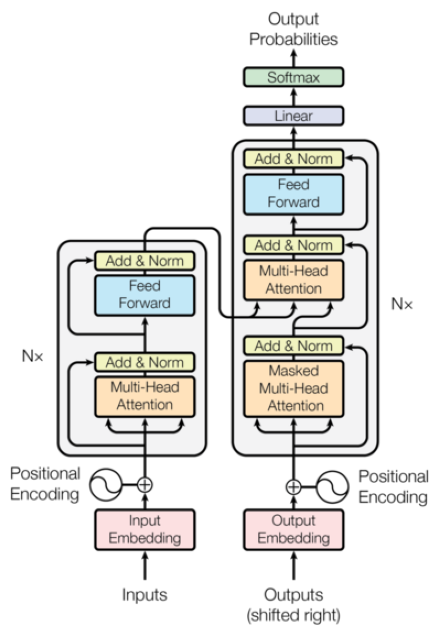

In [27]:
img = f'{os.getcwd()}/architecture.png'
image = Image.open(img)
plt.figure(figsize = (12,8))
plt.imshow(image)
plt.axis('off')  # To turn off axis numbers and ticks
plt.show()

In [28]:
def clones(module, N):
    """
    Produce N identical layers
    nn.ModuleList is basically a list with added functionality
        i.e. if you move to a device it moves all to device
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

**Batch Norm vs. Layer Norm:**

Typically, batch normalization normalizes across batches, whereas layer normalization normalizes across features. 

If you have $k$ batches each batch size $m$, then for each feature $f$, batch normalization ensures that the mean and variance of $f$ across all $m$ samples for each of the $k$ batches is the same (i.e. 0 and 1). In other words, all datapoints are treated equally.

On the other hand, layer normalization will normalize each feature. In other words, all features are treated equally.



In [29]:
class LayerNorm(nn.Module):
    "Construct a layernorm module."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # mean of relevant dim
        std = x.std(-1, keepdim=True)   # std  of relevant dim
        # epsilon small constant for numerical stability
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [30]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer sequentially"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself. We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these **residual connections**, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\mathrm{model}} = 512$.

**Notes::**

The residual connection (ResNet inspired) basically is a way for the neural network to learn a residual function $F(x)$ such that $y = F(x) + x$, where $y$ is the output. This is theoretically the same but in practice leaves a path for gradients to flow. Thus it allows you to have deeper networks (ResNet was simpler than other SOTA models but was deeper) and stabilizes training in general.

Of course you need to ensure the dimensions line up, hence everything outputs dim = 512

In [31]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the same size
        Only dropout to output of sublayer balances original info (x)
        and sublayer transforms. Also is computationally more efficient
        """
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [32]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # take input x and pass through multi-head self-attention mechanism sublayer
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # then feedforward sublayer
        return self.sublayer[1](x, self.feed_forward)

Decoder <br>
The decoder is also composed of a stack of $N = 6$ identical layers.

In [33]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        # memory is usually the output of the encoder
        # x is the start of the output seq
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [14]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # first attention
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))  # then attntn w.r.t encoder output as well
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

In [34]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # can't see future
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [37]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


example_mask()

alt.Chart(...)